## STEP1. 작업환경 구성하기


In [1]:
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import glob
import os
import time

from IPython import display


## STEP2. 데이터셋 구성하기  

- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화
- 로드한 학습 데이터를 시각화를 통해 확인  
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성

load_data()로 데이터를 로딩하는데, 분류문제와 달리 각 이미지가 어떤 카테고리인지 나타내주는 label이 필요없다.

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 4s 0us/step


(50000, 32, 32, 3)

In [3]:
# 32 x 32 필셀의 이미지, RGB 값으로 3을 가진다
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
# 학습에 사용할 train_x의 이미지를 -1, 1로 정규화
# 각 픽셀은 0 ~ 255사이의 정수값
train_x = train_x / 255.0
train_x = 2 * train_x - 1

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


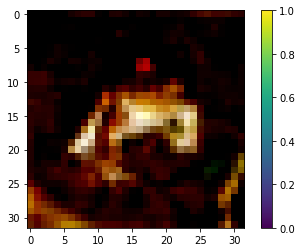

In [6]:
image = train_x[0]

plt.imshow(image)
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

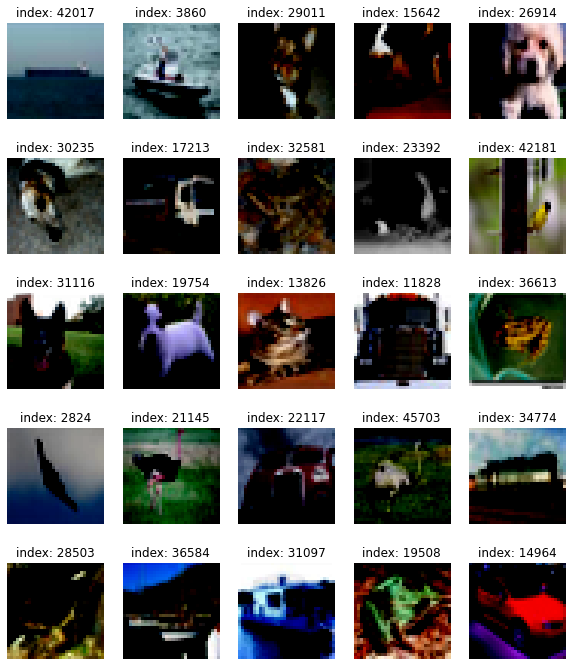

In [7]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index])
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [8]:
BUFFER_SIZE = 50000 # 전체 데이터 섞기
BATCH_SIZE = 256 # 모델이 한 번에 학습할 데이터의 양

In [9]:
# 미니 배치 학습
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## STEP3. 생성자 모델 구현하기

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

In [10]:
# (32, 32, 3)의 shape을 가진 이미지를 생성하는 생성자 모델 구현

def make_generator_model():
    
    model = tf.keras.Sequential()
    
    # First: Dense layer
    # units은 4x4x512, 편향 사용하지 않음, 입력 값의 크기 100차원
    model.add(layers.Dense(4 * 4 * 512, use_bias=False, input_shape=(100,)))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 512)))
    assert model.output_shape == (None, 4, 4, 512)

    # Third: Conv2DTranspose layer
    # 커널 크기는 5, stride는 2, 패딩 사용, 편향 사용하지 않음
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    # 커널 크기는 5, stride는 2, 패딩 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # six: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model
# Conv2DTranspose 층은 일반적인 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층

In [11]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              819200    
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 256)         0

In [12]:
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

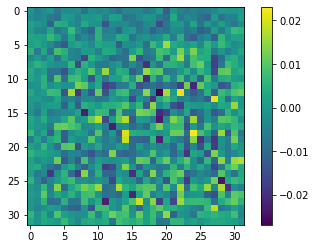

In [13]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## STEP4. 판별자 모델 구현하기

- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인

In [14]:
def make_discriminator_model():
    
    model = tf.keras.Sequential()
    
     # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model


In [15]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00016881]], dtype=float32)>

## STEP5. 손실함수와 최적화 함수 구현하기  

- 생성자와 판별자의 손실함수(loss)를 구현
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현
- 생성자와 판별자를 최적화하는 optimizer를 정의

GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용한다. 교차 엔트로피는 두 값이 가까워지기 원하는 것으로 얼마나 큰 차이가 나는 지 정량적으로 계산할 때 많이 쓰인다. 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개의 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용.

- Real Image에 대한 label을 1
- Fake Image에 대한 label을 0

각각의 손실함수를 이용해 정량적으로 달성해야 하는 결과는
- 생성자: 판별자가 Fake Image에 대해 판별한 값 즉, D(fake_Image)값이 1에 가까워지는 것
- 판별자:
    - Real Image 판별값, 즉 D(real_image)는 1에,
    - Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것
    
fake_output 과 real_output을 tf.ones_like()와 tf.zeros_like()함수를 이용해서 각각 1또는 0을 비교.

In [17]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
# generator_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_loss는 fake_output이 1에 가까워지기를 바라므로, tf.ones_like()와의 교차 엔트로피 값을 계산하면된다.
즉, cross_entropy(tf.ones_lik(fake_output), fake_output)값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가진다.

In [19]:
# discriminator_loss

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

discriminator_loss는 real_output값은 1에 가까워지기를,  
fake_output값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산.  
real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 된다.  
최종 discriminator_loss 값은 이 둘은 더한 값.

In [20]:
# discriminator accuracy

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [21]:
# optimizer 정의

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
# 100차원의 노이즈를 총 16개, (16, 100)형상의 벡터

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

생성할 샘플은 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있어서, 고정된 seed노이즈를 만들어야 함.  
100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만든다.

## STEP6. 훈련과정 상세 기능 구현하기

- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [23]:
# 미니배치의 훈련 과정을 처리하는 train_step() 함수 구현 

@tf.function
# (1) 입력 데이터
def train_step(images):
    
    # (2) 생성자 입력 노이즈
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    #(3) tf.GradientTape() 오픈
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #(4) generated_images 생성
      generated_images = generator(noise, training=True)

    #(5) discriminator 판별
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

    #(6) loss 계산
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
    #(7) accuracy 계산
      real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    #(10) 리턴값
    return gen_loss, disc_loss, real_accuracy, fake_accuracy  

In [24]:
# 이미지 생성 및 저장

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage_/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

한 단계씩 학습 할 train_step과 함께 일정 간격으로 학습 현황을 볼 수 있는 함수 설계  
만들어 놓은 고정된 seed를 이용해서 결과물을 만들어내므로, 고정된 seed에 대한 결과물이 개선되는 모습이 확인 가능함.

In [25]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage_/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [26]:
# 체크포인트 저장

import os

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage_/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP7. 학습 과정 진행하기  

- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 생성

지금까지 위에서 한 단계를 학습하는 train_step,  
샘플 이미지를 생성하고 저장하기 위한 generate_and_save_image(),  
학습과정을 시각화하는 drqw_train_history(),  
모델까지 저장하기 위한 checkpoint를 준비


In [27]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        # save_every 에포크가 지날 때마다 모델을 저장합니다.
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [28]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

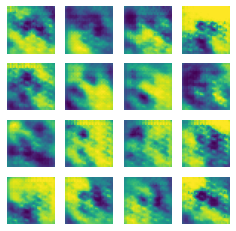

Time for training : 1896 sec


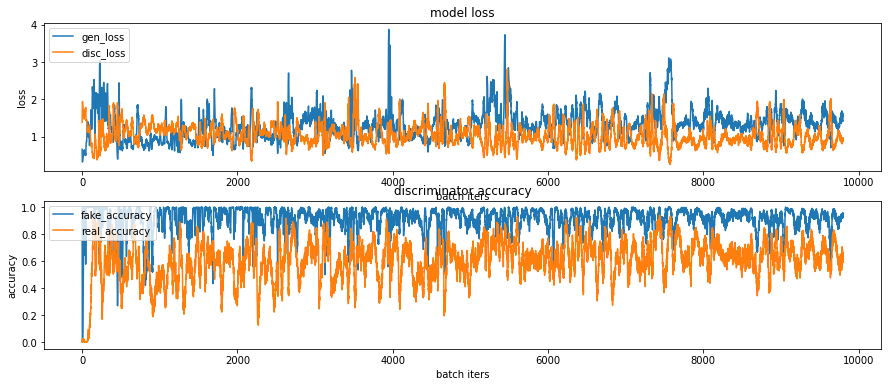

CPU times: user 31min 52s, sys: 1min 26s, total: 33min 18s
Wall time: 31min 37s


In [29]:
%%time
with tf.device('/GPU:0'):
    train(train_dataset, EPOCHS, save_every)

In [45]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage_/cifar10/dcgan_newimage.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage_/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/dcgan_newimage.gif

-rw-r--r-- 1 root root 1315956 Aug  2 03:51 /aiffel/aiffel/dcgan_newimage/cifar10/dcgan_newimage.gif


## STEP 8. (optional) GAN 훈련 과정 개선하기


In [46]:
def make_generator_model_two():
    
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8 * 8 * 128, activation = 'relu', input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum = 0.9))
    model.add(layers.LeakyReLU(alpha = 0.1))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 128)))

    # Third: Conv2D layer
    model.add(layers.Conv2D(128, kernel_size = 4, strides= 1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha = 0.1))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha = 0.1))

    # Fifth: Conv2D layer
    model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha = 0.1))

    # sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha = 0.1))
    
    # seventh: Conv2D layer
    model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha = 0.1))
    
    # eigth: Conv2D layer
    model.add(layers.Conv2D(3, kernel_size=5, strides=1, padding="same", activation='tanh'))

    return model

In [47]:
generator_two = make_generator_model_two()

generator_two.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_14 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 128)         262272    
_________________________________________________________________
batch_normalization_15 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 8, 8, 128)        

In [48]:
# 노이즈를 생성한다.
noise = tf.random.normal([1, 100])

generated_image = generator_two(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [49]:
def make_discriminator_model_two():
    
    model = tf.keras.Sequential()
    
     # First: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=3, strides=1, input_shape=(32, 32, 3), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
   
    model.add(layers.Flatten())
    
    model.add(layers.Dense(512, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model


In [50]:
discriminator_two = make_discriminator_model_two()

discriminator_two.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_21 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 16, 16, 128)      

In [51]:
# optimizer 정의

generator_optimizer = tf.keras.optimizers.Adam(beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(beta_1=0.5)


In [52]:
BUFFER_SIZE = 50000 # 전체 데이터 섞기
BATCH_SIZE = 16 # 모델이 한 번에 학습할 데이터의 양

In [38]:
save_every = 5
EPOCHS = 50

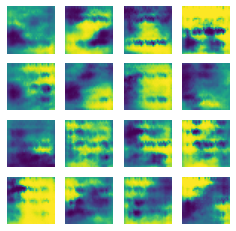

Time for training : 1906 sec


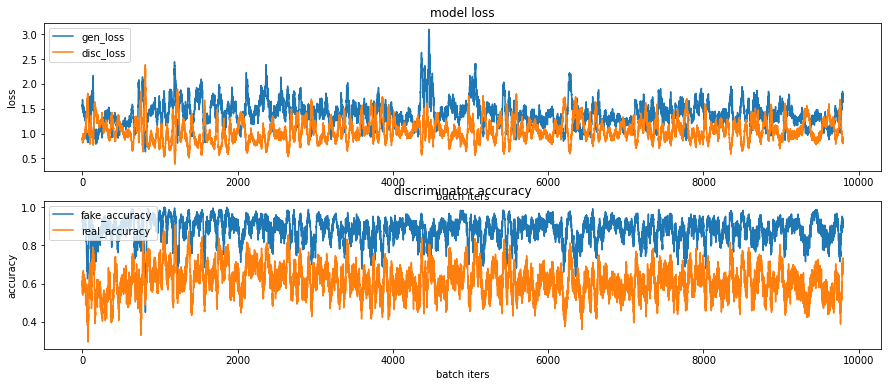

CPU times: user 32min, sys: 1min 25s, total: 33min 26s
Wall time: 31min 47s


In [39]:
%%time
train(train_dataset, EPOCHS, save_every)